# ネット上に弱異常検知で実装していたものがあったためそれをとりあえず動かす
参考URL  
https://qiita.com/shinmura0/items/1af83f5a5857d50cabc2  
https://github.com/shinmura0/Weakly-anomaly-detection/blob/master/WeaklyAnomalyDetection.ipynb

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

boots = 9#ブーツは9
sneaker = 7#スニーカーは7

# dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#学習データ
x_train_sum, x_train_s, x_train_b, x_test_s, x_test_b, = [], [], [], [], []
y_train_sum = []

for i in range(len(x_train)):
    if y_train[i] == boots:
        x_train_b.append(x_train[i])
    elif y_train[i] == sneaker:
        x_train_s.append(x_train[i])
    else:
        x_train_sum.append(x_train[i])
        y_train_sum.append(y_train[i])

x_train_sum = np.array(x_train_sum)
x_train_b = np.array(x_train_b)
x_train_s = np.array(x_train_s)
        
#trainデータからランダムに4000個抽出
number = np.random.choice(np.arange(0,x_train_sum.shape[0]),4000,replace=False)

x, y = [], []

for i in number:
    x.append(x_train_sum[i])
    y.append(y_train_sum[i])
    
x_train_sum = np.array(x)
y_train_sum = np.array(y)

In [2]:
#スニーカーデータからランダムに500個抽出
number = np.random.choice(np.arange(0,x_train_s.shape[0]),500,replace=False)

x, y = [], []

for i in number:
    x.append(x_train_s[i])

#データ結合
x_train_sum = np.vstack((x_train_sum, np.array(x)))
y_train_sum = np.hstack((y_train_sum, sneaker*np.ones(500)))

#ブーツデータからランダムに10個抽出
number = np.random.choice(np.arange(0,x_train_b.shape[0]),10,replace=False)

x, y = [], []

for i in number:
    x.append(x_train_b[i])
    
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False)
img = []

for d in datagen.flow(np.array(x), batch_size=1):
    # このあと画像を表示するためにndarrayをPIL形式に変換して保存する
    img.append(d[0])
    # datagen.flowは無限ループするため必要な枚数取得できたらループを抜ける
    if len(img) == 500:
        print("finish")
        break

#データ結合
x_train_sum = np.vstack((x_train_sum, np.array(img)))
y_train_sum = np.hstack((y_train_sum, boots*np.ones(500)))
y_train_sum = to_categorical(y_train_sum)

#テストデータ
for i in range(len(x_test)):
    if y_test[i] == 7:#スニーカーは7
        x_test_s.append(x_test[i])
    
    if y_test[i] == 9:#ブーツは9
        x_test_b.append(x_test[i])
    
x_test_s = np.array(x_test_s)
x_test_b = np.array(x_test_b)

print(x_train_sum.shape)
print(y_train_sum.shape)
print(x_test_s.shape)
print(x_test_b.shape)

finish
(5000, 28, 28, 1)
(5000, 10)
(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [4]:
import cv2
from PIL import Image

def resize(x):
    x_out = []
    
    for i in range(len(x)):
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img,dsize=(96,96))
        x_out.append(img)
                
    return np.array(x_out)

X_train_sum = resize(x_train_sum)
X_test_s = resize(x_test_s)
X_test_b = resize(x_test_b)

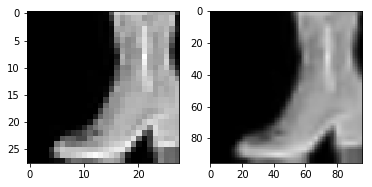

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_train_sum[4802,:,:,0], cmap='gray')
axs[1].imshow(X_train_sum[4802,:,:,:])
plt.show()

In [9]:
import keras
from keras.applications import MobileNetV2
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras import backend as K

from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


input_shape = (96, 96, 3)
classes = 10
batchsize = 128
alpha = 0.5

def train_and_evaluate(number, anomaly=True):
    # mobile net読み込み
    print("Model build...")
    
    mobile = MobileNetV2(include_top=True, input_shape=input_shape, alpha=alpha,
                     weights='imagenet')
    
    # 最終層削除
    mobile.layers.pop()
    model = Model(inputs=mobile.input,outputs=mobile.layers[-1].output)
            
    # L2層と全結合層を付ける
    c = keras.layers.Lambda(lambda xx: 5*(xx)/K.sqrt(K.sum(xx**2)))(model.output) #metric learning
    c = Dense(classes, activation='softmax')(c)
    model = Model(inputs=model.input,outputs=c)

    #model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(amsgrad=True),
                  metrics=['accuracy'])
    
    print(number,"training...")

    #cnnの学習
    if anomaly == True:
        train_NO = 5000
    else:
        train_NO = 4500

    hist = model.fit(X_train_sum[:train_NO],
                     y_train_sum[:train_NO],
                     batch_size=128,
                     epochs=50,
                     verbose = False)
    

    # 最終層削除
    model.layers.pop()
    model = Model(inputs=model.input,outputs=model.layers[-1].output)

    train = model.predict(X_train_sum[4000:4500])#スニーカー
    test_s = model.predict(X_test_s)
    test_b = model.predict(X_test_b)

    train = train.reshape((len(train),-1))
    test_s = test_s.reshape((len(X_test_s),-1))
    test_b = test_b.reshape((len(X_test_b),-1))

    #0-1変換
    ms = MinMaxScaler()
    train = ms.fit_transform(train)
    test_s = ms.transform(test_s)
    test_b = ms.transform(test_b)

    # LOF
    clf = LocalOutlierFactor(n_neighbors=5)
    y_pred = clf.fit(train)

    # plot the level sets of the decision function
    Z1 = -clf._decision_function(test_s)
    Z2 = -clf._decision_function(test_b)

    #ROC曲線の描画
    y_true = np.zeros(len(test_s)+len(test_b))
    y_true[len(test_s):] = 1#0:正常、1：異常

    # FPR, TPR(, しきい値) を算出
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

    # AUC
    auc = metrics.auc(fpr, tpr)
    
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='metric learning(AUC = %.2f)'%auc)
    plt.legend()
    plt.title(str(number)+'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

Model build...
1 training...


/home/ryamaguchi/wark/wark/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


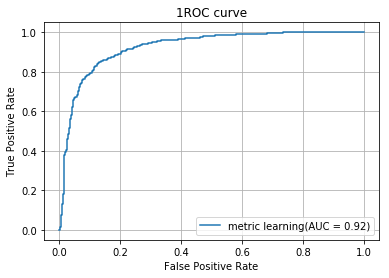

Model build...
2 training...


KeyboardInterrupt: 

In [10]:
#　普通の異常検知
for i in range(10):
    train_and_evaluate(i+1, False)
    
#　弱異常検知
for i in range(10):
    train_and_evaluate(i+1)